In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import Neccessary libraries
import numpy as np
import pandas as pd

# Import Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Import Model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score,roc_curve
from sklearn.pipeline import Pipeline

#Import Sampler libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

# Set the decimal format
pd.options.display.float_format = "{:.2f}".format

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis




In [2]:
df = pd.read_csv('diabetes_prediction_dataset.csv')
df.head()

gender   age  hypertension  heart_disease smoking_history   bmi  \
0  Female 80.00             0              1           never 25.19   
1  Female 54.00             0              0         No Info 27.32   
2    Male 28.00             0              0           never 27.32   
3  Female 36.00             0              0         current 23.45   
4    Male 76.00             1              1         current 20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0         6.60                  140         0  
1         6.60                   80         0  
2         5.70                  158         0  
3         5.00                  155         0  
4         4.80                  155         0

In [3]:
duplicate_rows_data = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_data.shape)
df = df.drop_duplicates()

number of duplicate rows:  (3854, 9)


In [4]:
# Loop through each column and count the number of distinct values
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

gender: 3 distinct values
age: 102 distinct values
hypertension: 2 distinct values
heart_disease: 2 distinct values
smoking_history: 6 distinct values
bmi: 4247 distinct values
HbA1c_level: 18 distinct values
blood_glucose_level: 18 distinct values
diabetes: 2 distinct values


In [5]:
# Checking null values
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [6]:
# Remove Unneccessary value [0.00195%]
df = df[df['gender'] != 'Other']

In [7]:
df.describe().style.format("{:.2f}")

In [8]:
df = df.drop("HbA1c_level", axis = 1)
df.head()

gender   age  hypertension  heart_disease smoking_history   bmi  \
0  Female 80.00             0              1           never 25.19   
1  Female 54.00             0              0         No Info 27.32   
2    Male 28.00             0              0           never 27.32   
3  Female 36.00             0              0         current 23.45   
4    Male 76.00             1              1         current 20.14   

   blood_glucose_level  diabetes  
0                  140         0  
1                   80         0  
2                  158         0  
3                  155         0  
4                  155         0

In [9]:
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 1
    elif smoking_status == 'current':
        return 2
    elif smoking_status in ['ever', 'former', 'not current']:
        return 3

# Apply the function to the 'smoking_history' column
df['smoking_history'] = df['smoking_history'].apply(recategorize_smoking)

# Check the new value counts
print(df['smoking_history'].value_counts())

1    67276
3    19655
2     9197
Name: smoking_history, dtype: int64


In [10]:
# Define a function to map the existing categories to new ones
def recategorize_gender(gender_status):
    if gender_status == 'Male':
        return 1
    elif gender_status == 'Female':
        return 0

# Apply the function to the 'smoking_history' column
df['gender'] = df['gender'].apply(recategorize_gender)

# Check the new value counts
print(df['gender'].value_counts())

0    56161
1    39967
Name: gender, dtype: int64


In [11]:
# Create a new column in the DataFrame for the new feature
glucose_level_column = df["blood_glucose_level"]
df["voltage_ratio"] = -0.276*glucose_level_column + 94.882
df = df.drop("blood_glucose_level", axis=1)
df.head(5)

gender   age  hypertension  heart_disease  smoking_history   bmi  diabetes  \
0       0 80.00             0              1                1 25.19         0   
1       0 54.00             0              0                1 27.32         0   
2       1 28.00             0              0                1 27.32         0   
3       0 36.00             0              0                2 23.45         0   
4       1 76.00             1              1                2 20.14         0   

   voltage_ratio  
0          56.24  
1          72.80  
2          51.27  
3          52.10  
4          52.10

In [12]:
df = df[['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'voltage_ratio', 'diabetes']]

print(df)

       gender   age  hypertension  heart_disease  smoking_history   bmi  \
0           0 80.00             0              1                1 25.19   
1           0 54.00             0              0                1 27.32   
2           1 28.00             0              0                1 27.32   
3           0 36.00             0              0                2 23.45   
4           1 76.00             1              1                2 20.14   
...       ...   ...           ...            ...              ...   ...   
99994       0 36.00             0              0                1 24.60   
99996       0  2.00             0              0                1 17.37   
99997       1 66.00             0              0                3 27.83   
99998       0 24.00             0              0                1 35.42   
99999       0 57.00             0              0                2 22.43   

       voltage_ratio  diabetes  
0              56.24         0  
1              72.80         0  


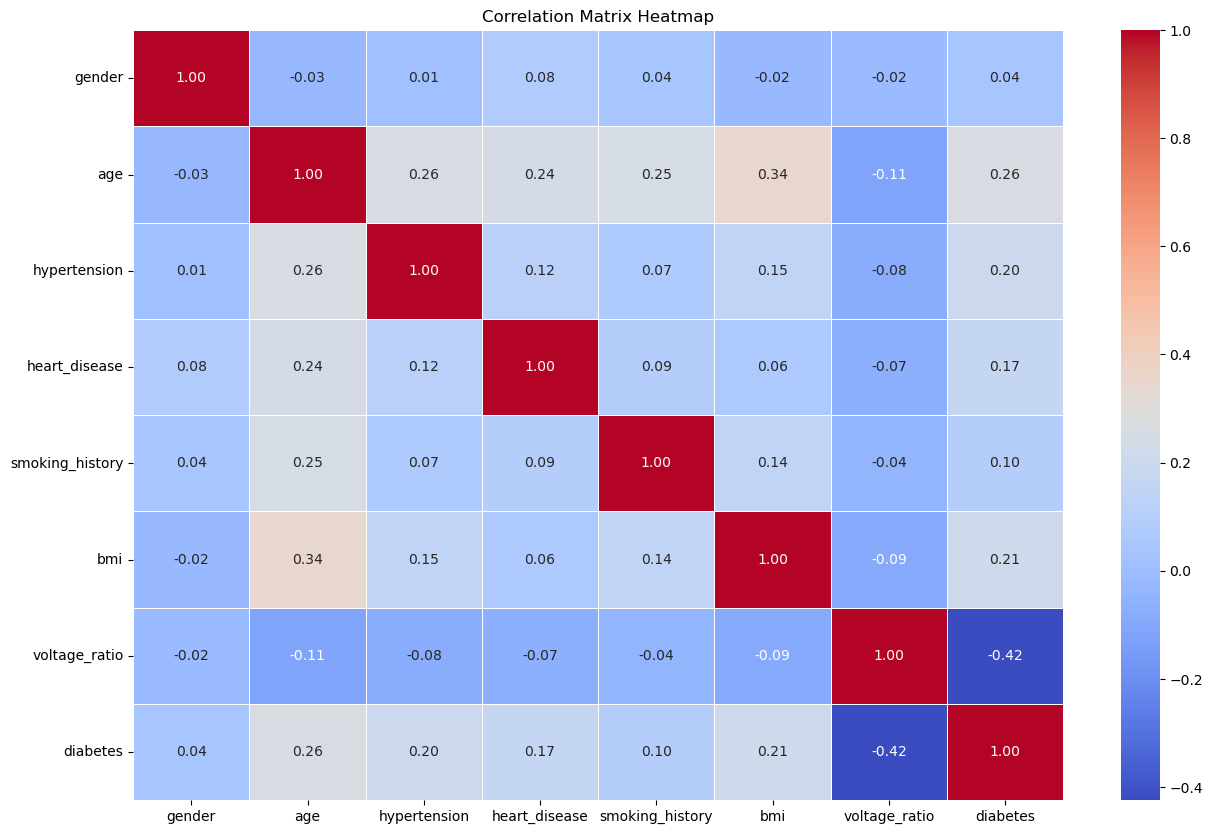

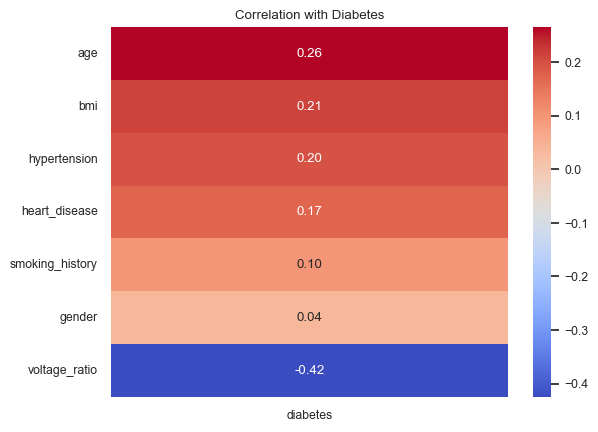

In [13]:
# Compute the correlation matrix
correlation_matrix = df.corr()
#Graph I.
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()


#Graph II
# Create a heatmap of the correlations with the target column
corr = df.corr()
target_corr = corr['diabetes'].drop('diabetes')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')
plt.show()

In [78]:
df_new = df.copy()


In [79]:
# Split data into features and target variable
X = df_new[['bmi', 'age', 'voltage_ratio']]
y = df_new['diabetes']


In [80]:
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)

In [81]:

steps = [('o', over), ('u', under)]
pipeline = imbPipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X, y)

In [95]:
# Import necessary libraries
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaler.fit(X) 

StandardScaler()

In [96]:
X

bmi   age  voltage_ratio
0     28.45 49.00          52.10
1     27.32 52.00          71.42
2     27.98 67.00          51.00
3     16.67  7.00          59.00
4     23.83 12.00          67.28
...     ...   ...            ...
52582 33.22 80.00          52.10
52583 32.06 69.00          56.24
52584 27.27 59.00          52.10
52585 27.32 57.00          54.86
52586 27.32 72.00          50.72

[52587 rows x 3 columns]

In [97]:

X_scaled = scaler.transform(X)
# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance
explained_variance = pca.explained_variance_
total_explained_variance = explained_variance.sum()

# Print results
print(f"Explained Variance:\n{explained_variance}")
print(f"Total Explained Variance: {total_explained_variance:.4f}")

Explained Variance:
[1.50580086 0.82247273 0.67178346]
Total Explained Variance: 3.0001


In [98]:
explained_variance_ratio = pca.explained_variance_ratio_
total_explained_variance_ratio = explained_variance_ratio.sum()

# Print results
print(f"\nExplained Variance Ratio:\n{explained_variance_ratio}")
print(f"Total Explained Variance Ratio: {total_explained_variance_ratio:.4f}")


Explained Variance Ratio:
[0.50192408 0.27415236 0.22392356]
Total Explained Variance Ratio: 1.0000


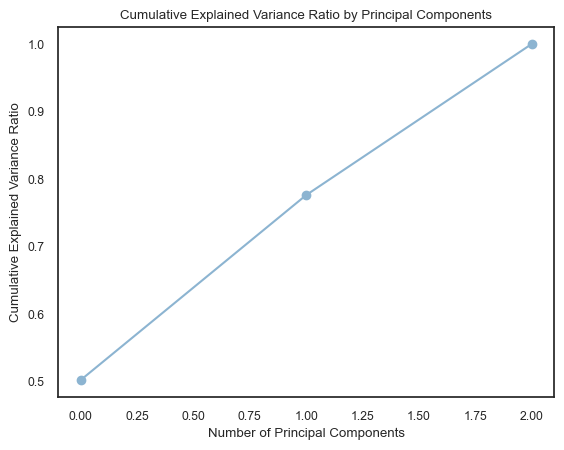

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# Plot explained variance ratio
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
plt.plot(cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Principal Components')
plt.show()

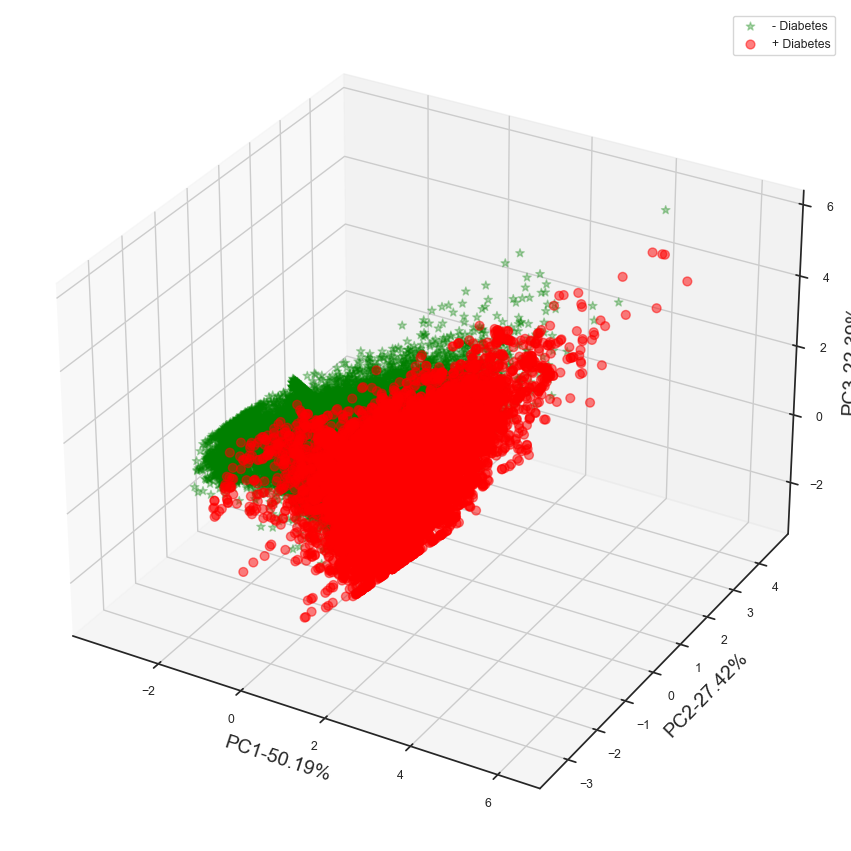

In [100]:
import numpy as np
import matplotlib.pyplot as plt

pc1 = str(round((explained_variance_ratio[0]*100),2))
pc2 = str(round((explained_variance_ratio[1]*100),2))
pc3 = str(round((explained_variance_ratio[2]*100),2))

Xax = X_pca[:,0]
Yax = X_pca[:,1]
Zax = X_pca[:,2]

cdict = {0:'green',1:'red'}
labl = {0:'- Diabetes',1:'+ Diabetes'}
marker = {0:'*',1:'o'}
alpha = {0:.3, 1:.5}

fig = plt.figure(figsize=(19.2,10.8))
ax = fig.add_subplot(111, projection='3d')

fig.patch.set_facecolor('white')
for l in np.unique(y):
 ix=np.where(y==l)
 ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l], s=40,
           label=labl[l], marker=marker[l], alpha=alpha[l])
# for loop ends
ax.set_xlabel("PC1-" + pc1 + "%", fontsize=14)
ax.set_ylabel("PC2-" + pc2 + "%", fontsize=14)
ax.set_zlabel("PC3-" + pc3 + "%", fontsize=14)

ax.legend()
plt.show()

In [101]:
import plotly.express as px


labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    X_pca,
    labels=labels,
    dimensions=range(3),
    color=y
)
fig.update_traces(diagonal_visible=False)
fig.show()